# LSTM for topic classification
---

In [1]:
import sys
import os
import json
from pathlib import Path

import torch
import pandas as pd
import gensim.downloader as api
from torch.utils.data import DataLoader

torch.manual_seed(42);

In [2]:
module_path = os.path.abspath(os.path.join('..\..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path
    sys.path.append(module_path + "/pytorch_tagging_models/data")
    sys.path.append(module_path + "/pytorch_tagging_models/models")
    sys.path.append(module_path + "/pytorch_tagging_models")

from ipynb_func import *

from lstm_dataset import Vocabularizer, DatasetLoader, w2v_embeds, tfidf_embeds
from lstm_trainer import Trainer
from lstm_model import LSTMClassifier

Data loader:

In [3]:
paths = [module_path + f"/data/pikabu/splited_data/cleared_texts.parquet"] 
data = merge_dataset(paths)

---
# 1. Data preparation and splits

In [4]:
with open(module_path + f"/data/pikabu/splited_data/indexes.json") as f:
    id_splits = f.read()

id_splits = json.loads(id_splits)

data_train = data[data['id'].isin(id_splits['train'])]
data_test = data[data['id'].isin(id_splits['test'])]
data_val = data[data['id'].isin(id_splits['val'])]

In [5]:
print(f"Number of train data: {len(data_train)}")
print(f"Number of val data: {len(data_val)}")
print(f"Number of test data: {len(data_test)}")
print(f"Distribution: {len(data_train)/len(data)*100:.0f} / {len(data_val)/len(data)*100:.0f} / {len(data_test)/len(data)*100:.0f}")

Number of train data: 25209
Number of val data: 2821
Number of test data: 3119
Distribution: 81 / 9 / 10


In [6]:
pd.set_option('display.max_colwidth', 130)
data_train.head(4)

,id,text_markdown,tags
15,6991359,"[добрый, сутки, господин, дама, подсказывать, название, игра, телефон, оформление, убийство, зомби, очки, ездить, машинка, кру...","[игры, поиск]"
37,7004423,"[ехать, девчонка, школа, оставаться, свободный, макс, заявка, прямой, конечный, адрес, железнодорожный, институт, включать, вб...",[юмор]
52,6991603,"[стадо, стадо, гигантский, случаться, стадо, управлять, волк, предел, волк, жопа, враг, дружно, осматривать, выдавливать, стад...",[мат]
58,7147306,"[бизнесмен, начало, нулевой, заниматься, диск, популярный, шляпа, бизнес, открываться, закрываться, бабло, капать, разный, про...","[люди, деньги, мат]"


---
# 2. Model training

In [7]:
save_models_path = module_path + '/models/lstm/'

Target preparation:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Vec = CountVectorizer(tokenizer=lambda x: x.split(','), binary=True)

df = data.copy()
df.tags = [','.join(i) for i in df.tags]

df_train = data_train.copy()
df_train.tags = [','.join(i) for i in df_train.tags]

df_val = data_val.copy()
df_val.tags = [','.join(i) for i in df_val.tags]

df_test = data_test.copy()
df_test.tags = [','.join(i) for i in df_test.tags]

y_data = Vec.fit(df['tags'])
y_train = Vec.transform([','.join(i) for i in data_train.tags])
y_val = Vec.transform([','.join(i) for i in data_val.tags])
y_test = Vec.transform([','.join(i) for i in data_test.tags])

y_train = y_train.toarray().tolist()
y_val = y_val.toarray().tolist()
y_test = y_test.toarray().tolist()

c:\Users\decique\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
tokenized_text = [i.tolist() for i in data.text_markdown]
vocabulary = Vocabularizer(tokenized_text)

X_train = [txt for txt in data_train.text_markdown]
X_val = [txt for txt in data_val.text_markdown]
X_test = [txt for txt in data_test.text_markdown]

train_dataset = DatasetLoader(X_train, y_train, vocabulary)
val_dataset = DatasetLoader(X_val, y_val, vocabulary)
test_dataset = DatasetLoader(X_test, y_test, vocabulary)

## 2.1. TF-IDF embeddings and training

In [10]:
X_data = ["<PAD>", "<UNK>", "<EOS>"] + [' '.join(txt) for txt in data.text_markdown]
X_train_tfidf = [' '.join(txt) for txt in data_train.text_markdown]

tfidf = TfidfVectorizer()
tfidf.fit(X_data)

tfidf_embeddings = tfidf_embeds(tfidf, X_data, vocabulary)

In [11]:
trainer_cfg = {"lr": 3e-3,
               "model_THR": 2.5,
               "n_epochs": 5,
               "weight_decay": 1e-6,
               "batch_size": 128,
               "device": "cuda" if torch.cuda.is_available() else "cpu"}

train_dataloader = DataLoader(train_dataset,
                              batch_size=trainer_cfg["batch_size"],
                              shuffle=True,
                              num_workers=0,
                              collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=trainer_cfg["batch_size"],
                            shuffle=False,
                            num_workers=0,
                            collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset,
                            batch_size=trainer_cfg["batch_size"],
                            shuffle=False,
                            num_workers=0,
                            collate_fn=val_dataset.collate_fn)

clf_model = LSTMClassifier(num_classes=60,
                           dropout_rate=0.2,
                           hidden_size_lstm=128,
                           num_layers_lstm=2,
                           dropout_rate_lstm=0.2,
                           bidirectional_lstm=True,
                           out_size=[200],
                           vocab=vocabulary,
                           embeds=tfidf_embeddings)

tf_idf_trainer = Trainer(trainer_cfg)

In [12]:
if os.path.isfile(save_models_path + 'tf_idf.ckpt'):
    print('Loading existing model...')
    tf_idf_trainer = Trainer.load(save_models_path + 'tf_idf.ckpt')
    print("Model loaded!\n")
    print('Model params:')
    print(tf_idf_trainer.model)
else:
    print('Training new model:\n')
    tf_idf_trainer.fit(clf_model, train_dataloader, val_dataloader)
    tf_idf_trainer.save(save_models_path + 'tf_idf.ckpt')

Loading existing model...
Model loaded!

Model params:
LSTMClassifier(
  (embeddings): Embedding(5902, 31152, padding_idx=0)
  (lstm): LSTM(31152, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (out_dropout): Dropout(p=0.2, inplace=False)
  (net): Sequential(
    (0): Linear(in_features=512, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=60, bias=True)
  )
)


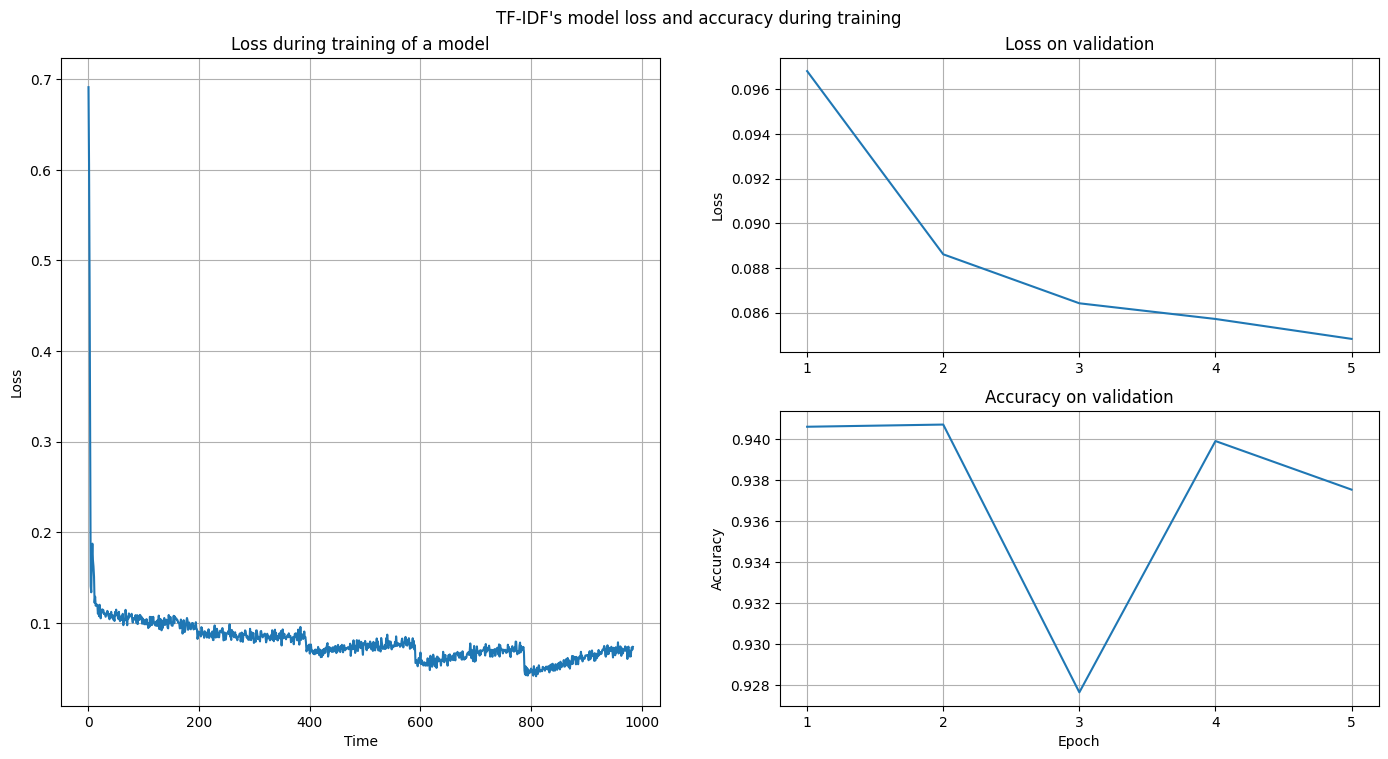

In [13]:
plot_model_history(tf_idf_trainer.history, title="TF-IDF's model loss and accuracy during training")

In [14]:
tf_idf_out = tf_idf_trainer.predict(val_dataloader)

In [15]:
THRESHOLD = trainer_cfg['model_THR']

df_val_tf_idf = df_val.copy()
df_val_tf_idf['predicted_tags'] = get_labels(tf_idf_out, Vec, THRESHOLD)
df_val_tf_idf['tags'] = [tags.split(',') for tags in df_val_tf_idf.tags]

In [16]:
df_val_tf_idf.head(5)

,id,text_markdown,tags,predicted_tags
421,6992880,"[популярный, пк, игра, создавать, устройство, проходить, картинка, память, оставаться, различный, создавать, написать, догадка...",[помогите найти],"[игры, история, юмор]"
432,6992917,"[профессия, оказываться, сопровождать, образование, курсы, обязанность, входить, хотеться, разговор, зажигать, свеча, оказыват...",[психология],"[работа, общество, реальная история из жизни, негатив]"
578,6994231,"[предыдущий, пост, бригада, график, переписывать, месяц, дата, окончание, поездка, графика, случаться, называть, двойной, поез...","[юмор, реальная история из жизни]","[юмор, отношения]"
591,6992488,"[широкий, хотеться, обращать, внимание, инцидент, связанный, дтп, участие, пожарный, двигаться, оперативный, вызов, включать, ...",[помощь],"[деньги, работа, лига юристов, помощь, юмор]"
807,7021892,"[история, скоро, девушка, упасть, дерево, парень, неловко, улыбаться, следовать, забывать, следить, окружение, темно, отзывать...","[рассказ, фантастика, мат]","[рассказ, фантастика, авторский рассказ, история, книги, мат]"


In [17]:
K = 5

recallk_tf_idf_mean, recallk_tf_idf_med = recallk(df_val_tf_idf.tags, df_val_tf_idf.predicted_tags, k=K)

print(f'Mean recall@k for k={K} for TF-IDF: {recallk_tf_idf_mean:.3f}')
print(f'Median recall@k for k={K} for TF-IDF: {recallk_tf_idf_med:.3f}')

Mean recall@k for k=5 for TF-IDF: 0.458
Median recall@k for k=5 for TF-IDF: 0.500


## 2.2 Word2Vec embeddings training

In [18]:
os.environ["GENSIM_DATA_DIR"] = str(Path.cwd())
w2v = api.load("word2vec-ruscorpora-300")
w2v_embeddings = w2v_embeds(w2v, vocabulary)

In [19]:
trainer_cfg = {"lr": 3e-3,
               "model_THR": 2.5,
               "n_epochs": 5,
               "weight_decay": 1e-6,
               "batch_size": 128,
               "device": "cuda" if torch.cuda.is_available() else "cpu"}

train_dataloader = DataLoader(train_dataset,
                              batch_size=trainer_cfg["batch_size"],
                              shuffle=True,
                              num_workers=0,
                              collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=trainer_cfg["batch_size"],
                            shuffle=False,
                            num_workers=0,
                            collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset,
                            batch_size=trainer_cfg["batch_size"],
                            shuffle=False,
                            num_workers=0,
                            collate_fn=val_dataset.collate_fn)

clf_model = LSTMClassifier(num_classes=60,
                           dropout_rate=0.2,
                           hidden_size_lstm=128,
                           num_layers_lstm=2,
                           dropout_rate_lstm=0.2,
                           bidirectional_lstm=True,
                           out_size=[200],
                           vocab=vocabulary,
                           embeds=w2v_embeddings)

w2v_trainer = Trainer(trainer_cfg)

In [20]:
if os.path.isfile(save_models_path + 'w2v.ckpt'):
    print('Loading existing model...')
    w2v_trainer = Trainer.load(save_models_path + 'w2v.ckpt')
    print("Model loaded!\n")
    print('Model params:')
    print(w2v_trainer.model)
else:
    print('Training new model:\n')
    w2v_trainer.fit(clf_model, train_dataloader, val_dataloader)
    w2v_trainer.save(save_models_path + 'w2v.ckpt')

Loading existing model...
Model loaded!

Model params:
LSTMClassifier(
  (embeddings): Embedding(5902, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (out_dropout): Dropout(p=0.2, inplace=False)
  (net): Sequential(
    (0): Linear(in_features=512, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=60, bias=True)
  )
)


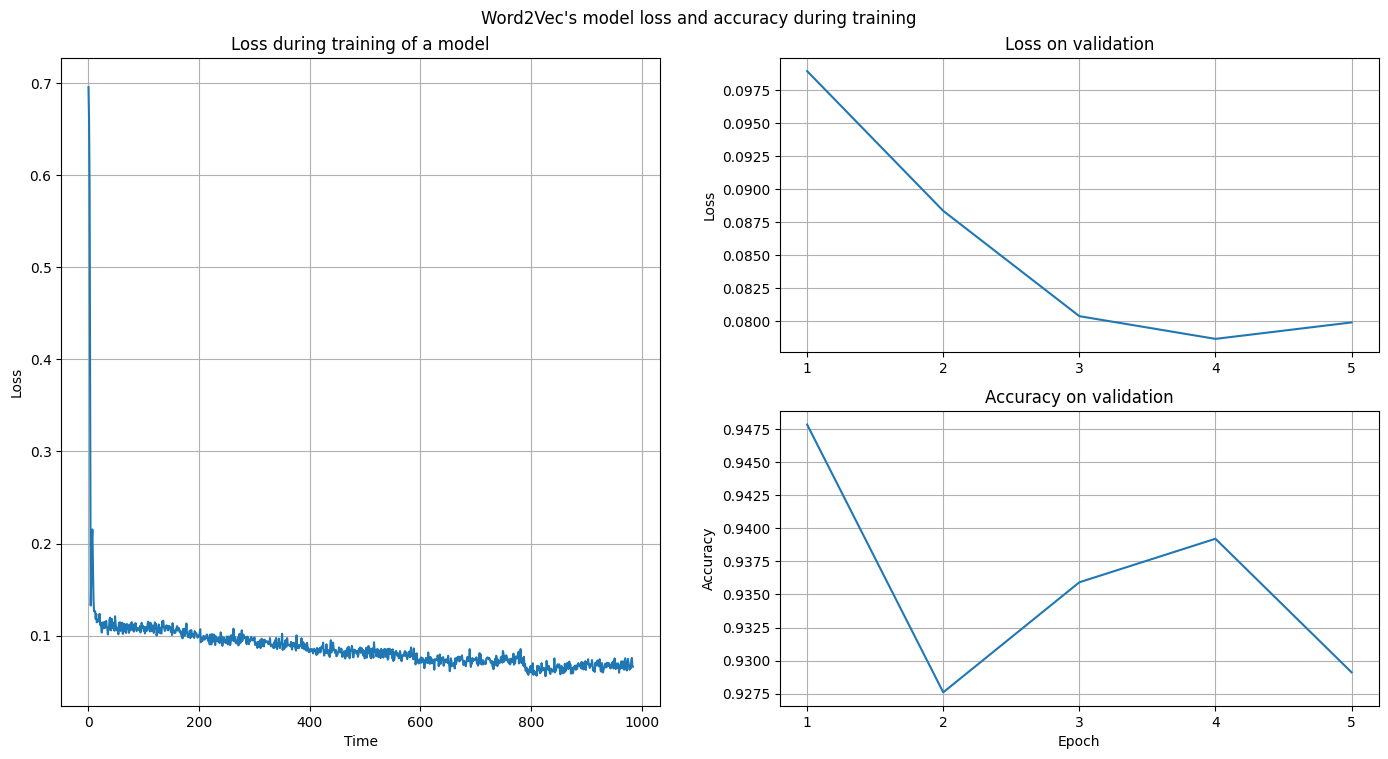

In [21]:
plot_model_history(w2v_trainer.history, title="Word2Vec's model loss and accuracy during training")

In [22]:
w2v_out = w2v_trainer.predict(val_dataloader)

In [23]:
THRESHOLD = trainer_cfg['model_THR']

df_val_w2v = df_val.copy()
df_val_w2v['predicted_tags'] = get_labels(w2v_out, Vec, THRESHOLD)
df_val_w2v['tags'] = [tags.split(',') for tags in df_val_w2v.tags]

In [24]:
df_val_w2v.head(5)

,id,text_markdown,tags,predicted_tags
421,6992880,"[популярный, пк, игра, создавать, устройство, проходить, картинка, память, оставаться, различный, создавать, написать, догадка...",[помогите найти],"[игры, помогите найти, помощь, поиск, фильмы]"
432,6992917,"[профессия, оказываться, сопровождать, образование, курсы, обязанность, входить, хотеться, разговор, зажигать, свеча, оказыват...",[психология],"[медицина, мат, психология, школа]"
578,6994231,"[предыдущий, пост, бригада, график, переписывать, месяц, дата, окончание, поездка, графика, случаться, называть, двойной, поез...","[юмор, реальная история из жизни]","[мат, работа, юмор]"
591,6992488,"[широкий, хотеться, обращать, внимание, инцидент, связанный, дтп, участие, пожарный, двигаться, оперативный, вызов, включать, ...",[помощь],"[помощь, лига юристов, москва, работа]"
807,7021892,"[история, скоро, девушка, упасть, дерево, парень, неловко, улыбаться, следовать, забывать, следить, окружение, темно, отзывать...","[рассказ, фантастика, мат]","[рассказ, история, авторский рассказ]"


In [25]:
w2v_recall_mean, w2v_recall_med = recallk(df_val_w2v.tags, df_val_w2v.predicted_tags, k=K)

print(f'Mean recall@k for k={K} for word2vec: {w2v_recall_mean:.3f}')
print(f'Median recall@k for k={K} for word2vec: {w2v_recall_med:.3f}')

Mean recall@k for k=5 for word2vec: 0.521
Median recall@k for k=5 for word2vec: 0.500


---
## 3. Results

As the result of training we have the following:

In [26]:
print(f"Mean recall@k's for LSTM with k = {K}:")
print(f'  • Recall@k for TF-IDF: {recallk_tf_idf_mean:.4f}')
print(f'  • Recall@k for word2vec: {w2v_recall_mean:.4f}')

print(f"\nMedian recall@k's for LSTM with k = {K}:")
print(f'  • Recall@k for TF-IDF: {recallk_tf_idf_med:.4f}')
print(f'  • Recall@k for word2vec: {w2v_recall_med:.4f}')

Mean recall@k's for LSTM with k = 5:
  • Recall@k for TF-IDF: 0.4584
  • Recall@k for word2vec: 0.5211

Median recall@k's for LSTM with k = 5:
  • Recall@k for TF-IDF: 0.5000
  • Recall@k for word2vec: 0.5000
